In [1]:
from _bootstrap import PROJECT_ROOT, RESULTS_DIR, FIGURES_DIR, DEFAULT_SEEDS

[bootstrap] PROJECT_ROOT = /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe
[bootstrap] RESULTS_DIR  = /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe/results
[bootstrap] FIGURES_DIR  = /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe/figures


In [2]:
from src.config import SimConfig, MetricsConfig
from src.experiments import run_sweep, summarize

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from _bootstrap import RESULTS_DIR, FIGURES_DIR, DEFAULT_SEEDS
from src.config import SimConfig, MetricsConfig
from src.experiments import run_sweep, summarize

In [4]:
A_values = np.linspace(0.0, 0.15, 6)          # 6
noise_values = np.linspace(0.0, 0.08, 6)      # 6
seeds = [0, 1]                                # 2

SIM = SimConfig(
    N=300,
    steps=600,         
    save_every=60,     
    attraction=0.10,
    noise=0.03,
    interaction_range=0.30,
)

MET = MetricsConfig(
    eps=0.06,
    bins=20,
    min_size=3,
    burn_frac=0.6,
)

## Phase diagram in the (A, noise) plane

We construct a two-dimensional phase diagram by jointly varying the attraction strength A and the noise amplitude σ.
This allows us to identify regions of disordered, clustered, and noise-dominated behaviour.

In [5]:
from dataclasses import asdict
import time

rows = []
t0 = time.time()

for i, A in enumerate(A_values):
    SIM_A = SimConfig(**{**asdict(SIM), "attraction": float(A)})

    df_raw = run_sweep(
        SIM_A, MET,
        sweep_name="noise",
        sweep_values=noise_values,
        seeds=seeds,
    )
    df_raw["attraction"] = float(A)
    rows.append(df_raw)

  
    df_tmp = pd.concat(rows, ignore_index=True)
    df_tmp.to_csv(RESULTS_DIR / "phase_raw_checkpoint.csv", index=False)

    print(f"[{i+1}/{len(A_values)}] A={A:.3f} done | elapsed={time.time()-t0:.1f}s")

df_phase = pd.concat(rows, ignore_index=True)
df_phase.to_csv(RESULTS_DIR / "phase_raw.csv", index=False)
df_phase.head()

[1/6] A=0.000 done | elapsed=22.8s
[2/6] A=0.030 done | elapsed=45.1s
[3/6] A=0.060 done | elapsed=67.4s
[4/6] A=0.090 done | elapsed=90.4s
[5/6] A=0.120 done | elapsed=113.6s
[6/6] A=0.150 done | elapsed=137.0s


,seed,noise,nn_mean,densvar_mean,lcf_mean,nclusters_mean,lcf_time_std,runtime_sec,attraction
0,0,0.000,0.049712,0.491111,0.950000,5.00,0.000000,1.937769,0.0
1,1,0.000,0.049688,0.488889,0.993333,3.00,0.000000,1.910171,0.0
2,0,0.016,0.028468,1.260000,0.233333,33.00,0.052546,1.873014,0.0
3,1,0.016,0.030791,1.224444,0.322500,30.25,0.121572,1.874780,0.0
4,0,0.032,0.028533,1.313333,0.355000,26.75,0.078899,1.905017,0.0


In [6]:
df_phase_sum = (
    df_phase
    .groupby(["attraction", "noise"])
    .agg({
        "lcf_mean": "mean",
        "nn_mean": "mean",
    })
    .reset_index()
)

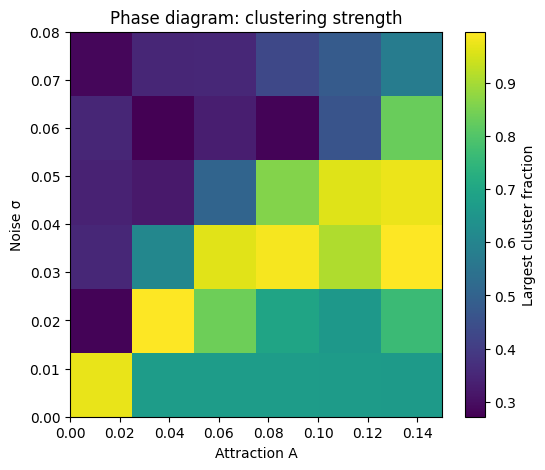

In [7]:
pivot = df_phase_sum.pivot(
    index="noise", columns="attraction", values="lcf_mean"
)

plt.figure(figsize=(6,5))
plt.imshow(
    pivot.values,
    origin="lower",
    aspect="auto",
    extent=[
        pivot.columns.min(), pivot.columns.max(),
        pivot.index.min(), pivot.index.max()
    ],
)
plt.colorbar(label="Largest cluster fraction")
plt.xlabel("Attraction A")
plt.ylabel("Noise σ")
plt.title("Phase diagram: clustering strength")
plt.show()